# Solving the Pendulum Motion with Missing Data

> **Introduction:** This is the Question 4 of APOAI 2025 Mock Competition, and it is also the fourth question of the NOAI 2024 (China).

## I. Question Overview

A dataset for pendulum motion is provided, which is stored in a .csv file and contains two variables:

- `t`: Time, unit: second (s), it is in the standard unit, and there is no need to consider unit conversion during the problem-solving process;
- `theta`: The angle of the pendulum, with positive and negative values indicating the direction, and the unit is radian; that is, there is no need to consider unit conversion when using the sin function for operations.

Based on the above dataset, please use PyTorch to regress the relevant parameters of the pendulum motion with resistance, fill in the missing data and make predictions.

## II. Data Set

There are three datasets.

1. Training set: `pendulum_train.csv`, Address of the training set: [Training Set](https://bohrium.dp.tech/competitions/1723157880?tab=datasets);
2. Test set A: `pendulum_testA.csv`. Contestants cannot directly download Test set A during the competition;
3. Test set B: `pendulum_testB.csv`. Contestants cannot directly download Test set B during the competition.

The data in the training set is all visible, which can help contestants generate methods for solving parameters. The data of Test set A is invisible to contestants, but it will be displayed in the Leaderboard A, which can help contestants verify whether the method for solving parameters is correct. The data of Test set B is invisible to contestants and will finally be used when calculating scores in the Leaderboard B.

> **Note:** The differential equation parameters of the training set, Test set A and Test set B are all different. What contestants need to submit is a solution method that can be applied to different data. When importing different data sets, that is, when importing the training set, Test set A and Test set B, the correct parameters can be solved.

## III. Task

In machine learning, we sometimes encounter scenarios where we need to extract the patterns in data with a small amount of data. In such scenarios, how to make full use of prior knowledge (formulas) to process data, design models and successfully solve unknown parameters is the key to solving the problem. Now consider a pendulum scenario.

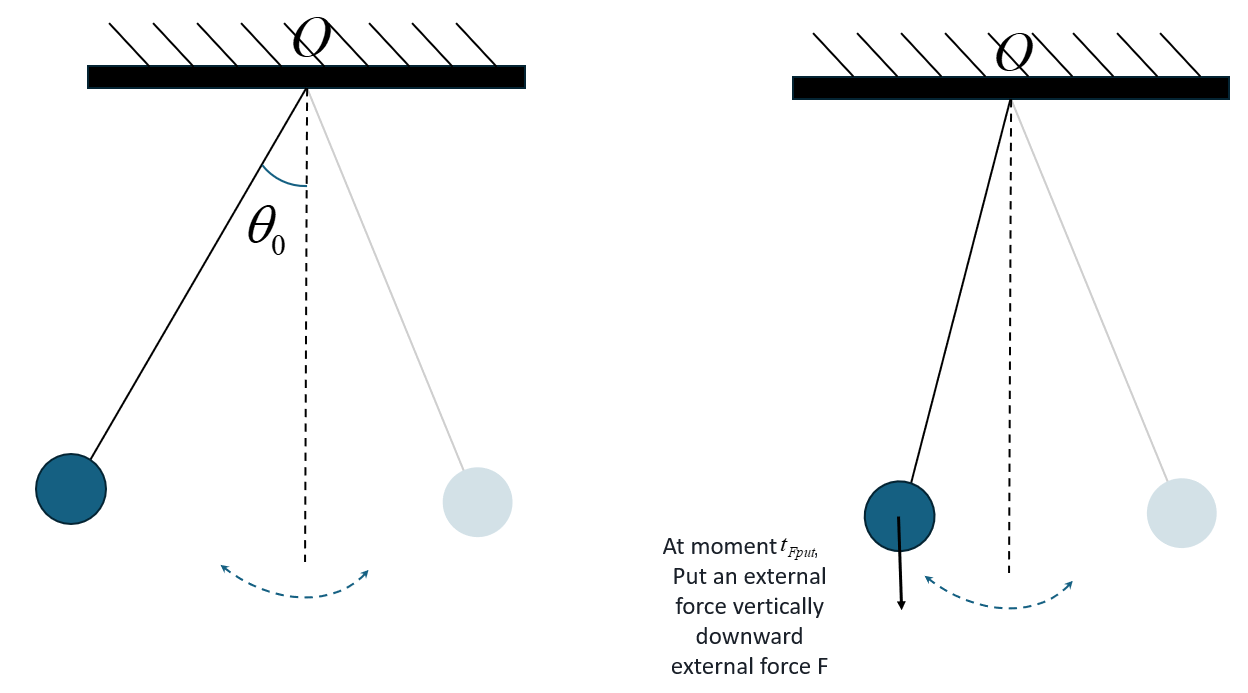

As shown in the above figure, there is a small ball with a mass of 1 ($m=1$) that can be regarded as a particle, which is suspended by a light rope with a length of $l$ at a fixed point $O$. Let $\theta(t)$ be the angle between the rope and the vertical line passing through $O$ at time $t$, which is called the pendulum angle.

Stretch the rope straight and release the small ball with an initial pendulum angle $\theta_0 < \pi / 2$ (in radian measure). If you don't understand radian measure, you can ask a large language model). At $t=0$, release the small ball without an initial velocity, and then the small ball can move in the plane corresponding to the light rope and the vertical line. Here, taking the initial pendulum angle $\theta_0$ as positive, when the small ball is on the left side of the vertical line, the sign of the pendulum angle $\theta(t)$ is recorded as positive, and when it is on the right side of the vertical line, the sign of the pendulum angle $\theta(t)$) is recorded as negative. 

Let the acceleration due to gravity be $g=9.8$ (during the whole problem-solving process, there is no need to consider unit conversion, and you can directly operate on the numerical values).

Consider the air resistance whose magnitude is proportional to the velocity and whose direction is opposite to the velocity, and the magnitude of the air resistance $\mu$ remains constant during the motion.

There is a sensor that can accurately record the pendulum angle of the small ball. However, during the experiment, the sensor had a problem. It suddenly interrupted for several seconds ($\ge 1s$) during the recording and was restarted only after that, and it stopped working before the small ball stopped moving. It is known that starting from a certain moment $t_{F_{\text{put}}}$ during the interrupted period, the small ball was subjected to a constant external force $F$ in the vertical downward direction, and this continued until the end of the motion.

Please try to infer and predict the situation of the small ball based on the recorded data. The data is in the .csv file, which includes two columns. The first column records the time stamp $t$ of the small ball's motion, represented by the variable `t`, and the second column records the pendulum angle information $\theta$ of the small ball, represented by the variable `theta`. We plot the pendulum angle data $\theta(t)$ in the training set as follows:

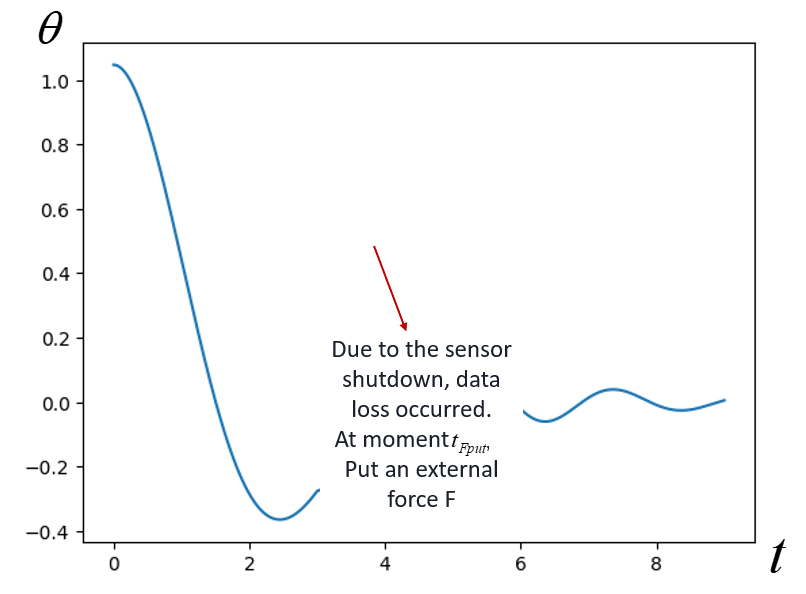

To solve this problem, you need to have prior knowledge of differential equations. During the whole motion process, the angular velocity $\omega(t)$ refers to the instantaneous change rate of $\theta(t)$ (with positive and negative values), and the angular acceleration $a(t)$ refers to the instantaneous change rate of the angular velocity $\omega(t)$ (with positive and negative values), that is, $\omega(t) = \frac{d\theta(t)}{dt}$, $a(t) = \frac{d\omega(t)}{dt}$ (if you don't understand derivatives, you can ask a large language model). Then, in the above pendulum problem, $a(t)$ should satisfy the following differential equation with $\omega(t)$ and $\theta(t)$:

$$
a(t) = -\alpha \cdot \omega(t) - \beta \sin \left( \theta(t) \right ) ,
$$

where $\alpha$ and $\beta$ are parameters. According to Newton's second law, 

- $\alpha = \frac{\mu}{m}$.
- When $0 \le t \lt t_{F_{\text{put}}}$, no external force is applied. At this time, $\beta = \beta_1 = \frac{g}{l}$; \
  When $t \ge t_{F_{\text{put}}}$, an external force $F$ is applied. At this time, $\beta = \beta_2 = \frac{g}{l} + \frac{F}{ml}$.

Using the differential equation, if $\alpha$, $\beta_1$, and $\beta_2$ are known, when the angular velocity $\omega(t)$ and the pendulum angle $\theta(t)$ at time $t$ are known, $a(t)$ can be calculated according to the differential equation.

However, the problem in this question is that $\alpha$, $\beta_1$, and $\beta_2$ are unknown, and only the pendulum angle data $\theta(t)$ recorded at each moment is available. You need to "regress" $\alpha$, $\beta_1$, and $\beta_2$ according to the provided data. This is the core task in this question.

After obtaining $\alpha$, $\beta_1$, and $\beta_2$, it is equivalent to obtaining the entire differential equation, and then you can use the differential equation to complete and predict the pendulum angle data of the small ball.

Specifically, you need to solve the following parameters according to the time $t$ and $\theta(t)$ data recorded in the .csv file:

1. The length of the rope: $l$;
2. The air resistance: $\mu$;
3. The magnitude of the external force applied in the middle: $F$;
4. Predict the moment when the pendulum angle $\theta(t) = 0$ after the sensor detection ends (after the data recording ends) and after the external force is applied: $t_{\text{nextzerotheta}}$;
5. The time when the external force is applied: $t_{F_{\text{put}}}$.

## IV. Submission

Please submit the `submission.ipynb` file, which contains the entire process of training the model and the entire process of parameter solution.

The `submission.ipynb` needs to be able to generate three files:

1. The parameter solution results of the training set are stored in `submission_train.csv`;
2. The parameter solution results of Test set A are stored in `submissionA.csv`;
3. The parameter solution results of Test set B are stored in `submissionB.csv`.

The storage format of the parameters is shown in the following table. If some parameters are not solved, please fill in a default parameter, for example, 1, and do not leave it blank:

| l | miu | F | t_nextzerotheta | t_Fput |
| --- | --- | --- | --- | --- | 
| 1 | 1 | 10 | 1 | 1 |

You can refer to the submission format in `baseline.ipynb`.

`baseline.ipynb` address: [Question 4 of APOAI2025 Mock Competition_baseline](https://bohrium.dp.tech/notebooks/47347521216).

## V. Scoring

1. The final scoring matrix is as follows: where $X_{\text{pre}}$ is the predicted value of parameter $X$ by the contestant, and $X_{\text{real}}$ is the real value of parameter $X$;
    1. Scoring for solving the length of the rope $l$: $S_1 = \exp(−10 | l_{\text{pre}} − l_{\text{real}} |)$;
    2. Scoring for solving the air resistance $\mu$: $S_2 = \exp(−10 | \mu_{\text{pre}} − \mu_{\text{real}} |)$;
    3. Scoring for solving the external force $F$: $S_3 = \exp(| F_{\text{pre}} − F_{\text{real}} |)$;
    4. Scoring for solving the moment when the next pendulum angle $\theta(t) = 0$, $t_{\text{nextzerotheta}}$: $S_4 = \exp(-10 | {t_{\text{nextzerotheta}}}_{\text{pre}} − {t_{\text{nextzerotheta}}}_{\text{real}} |)$;
    5. Scoring for solving the moment when the external force is applied, $t_{F_{\text{put}}}$: $S_5 = \exp(| {t_{F_{\text{put}}}}_{\text{pre}} − {t_{F_{\text{put}}}}_{\text{real}} |)$;
    6. Final score: $\text{Score} = \frac{S_1 + S_2 + 2S_3 + S_4 + 2S_5}{8}$.
2. If the submission is not in the required format: 0 points.

## VI. Appendix (Hint): A Case of Xiao Ai (LLM) Using PyTorch to Solve the Differential Equation with Resistance

There is a small ball that can be regarded as a particle and is in linear motion with resistance.

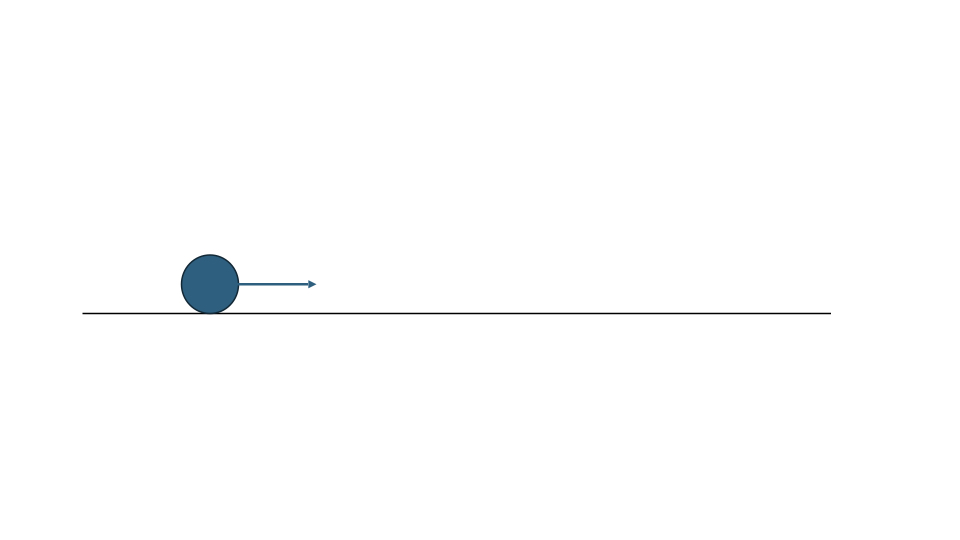

Among them, the displacement is $s(t)$, the velocity is $v(t) = \frac{ds(t)}{dt}$, and the acceleration is $a(t)= \frac{dv(t)}{dt}$. The small ball is subjected to two resistances, one resistance is proportional to the current velocity, and the other resistance is proportional to the current displacement. That is, the motion of the small ball satisfies the following differential equation:

$$
a(t) = -\alpha v(t) - \beta s(t) ,
$$

where $\alpha$ is the resistance parameter proportional to the velocity, and $\beta$ is the resistance parameter proportional to the displacement.

Xiao Ai recorded the data of the motion process in `sv_data.csv`, including two columns of data:

- `t`: Time, unit: s, which is the standard unit, and there is no need to consider unit conversion.
- `s`: Displacement, unit: m, which is the standard unit, and there is no need to consider unit conversion.

Xiao Ai wrote code using PyTorch to "regress", solved $\alpha$ and $\beta$, determined the differential equation, and predicted the displacement and velocity of the small ball after another 5 seconds. The code for his solution process is as follows:

```python
import numpy as np
import torch
from torch import nn
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import math

### Define derivative/difference operation ###
def derivative(t, s):  # Use difference instead of derivative, can use recorded displacement values to calculate velocity
   dsdt = (s[1:] - s[:-1]) / (t[1:] - t[:-1])  # This means each time using difference to find derivative, array size decreases by 1, s records n data points, then v can only record n-1 data points
   return dsdt

def load_data(csv_path):  # Read displacement and time data 
   data = pd.read_csv(csv_path)   
   t = np.array(data["t"])  #R ead time
   s = np.array(data["s"])  # Read displacement
   return t, s

### Read data ###
csv_path = "sv_data.csv"   
t, s = load_data(csv_path)  # Read data
v = derivative(t, s)  # Calculate velocity at each time point

### Define network for solving (regressing) differential equation parameters ###
class StraightLine(nn.Module):  # Use Pytorch to build differential equation model
   def __init__(self):
       super().__init__()
       self.alpha = nn.Parameter(torch.randn((1,), requires_grad=True))  # Need to record parameters, requires_grad = True can always remain unchanged, as default parameter
       self.beta = nn.Parameter(torch.randn((1,), requires_grad=True)) 

   def forward(self, theta, omega, add_force=False):
       a = - self.alpha * omega - self.beta * theta  # Differential equation
       return a

### Unify array sizes for displacement s, velocity v, acceleration a: s needs to remove last two values, v needs to remove last value, a doesn't need removal ###
# To import data into PyTorch, need to convert np.array and list to torch.tensor, code as follows
a = torch.from_numpy(derivative(t[:-1], v))  # Each time using difference to find derivative, array size decreases by 1
v = torch.from_numpy(v[:-1])  # Each time using difference to find derivative, array size decreases by 1, s records n data points, then v can only record n-1 data points, a can only record n-2 data points
s = torch.from_numpy(s[:-2])  # Each time using difference to find derivative, array size decreases by 1, s records n data points, then v can only record n-1 data points, a can only record n-2 data points

### Start training ###
num_epoch = 20000  # Training for 20000 epochs should be enough
model = StraightLine()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### Extract model parameters and print ####
alpha = (model.alpha).detach().item()  # Print model parameters, drag coefficient related to v
beta = (model.beta).detach().item()  # Print model parameters, drag coefficient related to s
print("alpha: {}".format(alpha))
print("beta: {}".format(beta))

#### Method using odeint library to solve differential equations ###
def v_func(sv, t, alpha, beta):  # Define a differential equation; inputs are sv (a pair of values, displacement s and velocity v respectively); t is time; just write it like this; alpha and beta are drag coefficients related to v and s, respectively
   s, v = sv 
   a = - alpha * v - beta * s  # Differential equation
   return np.array([v, a])

sv_expect = odeint(v_func, [s[-1], v[-1]], [0,5], args=(alpha, beta))  # Print displacement and velocity after 5 seconds, where s[-1] and v[-1] extract the last value, representing current position; 0 represents current time, 5 represents 5 seconds later
print("Displacement s after 5 more seconds:", sv_expect[1, 0]) # First column is displacement, first row is displacement at current time
print("Velocity v after 5 more seconds:", sv_expect[1, 1]) # Second column is velocity, second row is velocity at current time
```

## Analysis

> In Part III, the author uses $a(t)$ for angular acceleration, but I choose to use it as tangential acceleration below. Take note that they are different and I rederive the differential equation above from my point of view.

The pendulum undergoes simple harmonic motion, and its tangential acceleration, $a(t)=l \frac{d\omega(t)}{dt}=l \frac{d^2\theta(t)}{dt^2}$, is governed by three forces:

- the tangential component of gravity, $F_g(t) = -mg\sin\theta(t)$,
- the frictional (air resistance) force, $f(t)=-\mu v(t)=-\mu l\omega(t)$, and
- the tangential component of the downward pulling force, $F_d(t)$. ($F_d(t)=-F\sin\theta(t)$ when $t\ge t_F$ and zero otherwise.)

Apply Newton's second law, we get

$$
ml \frac{d^2\theta(t)}{dt^2} = -mg\sin\theta(t) - \mu l\frac{d\theta(t)}{dt} - F_d(t).
$$

Given datapoints $(t, \theta(t))$, we want to find paramters $l$, $\mu$, $F$, $t_F$.

## Load data

In [1]:
import os
import random
import torch
import zipfile
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.integrate import solve_ivp

TEST_PATH = Path(os.environ.get("DATA_PATH") or "")  # For grader
TRAIN_PATH = Path("")
if TEST_PATH != TRAIN_PATH:
    TRAIN_PATH = Path("/bohr/train-08bw/v1")

seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
df_train = pd.read_csv(TRAIN_PATH / "pendulum_train.csv")
df_train

,t,theta
0,0.000000,1.050000
1,0.015015,1.049805
2,0.030030,1.049222
3,0.045045,1.048253
4,0.060060,1.046903
...,...,...
729,14.939940,-0.003654
730,14.954955,-0.004669
731,14.969970,-0.005666
732,14.984985,-0.006643


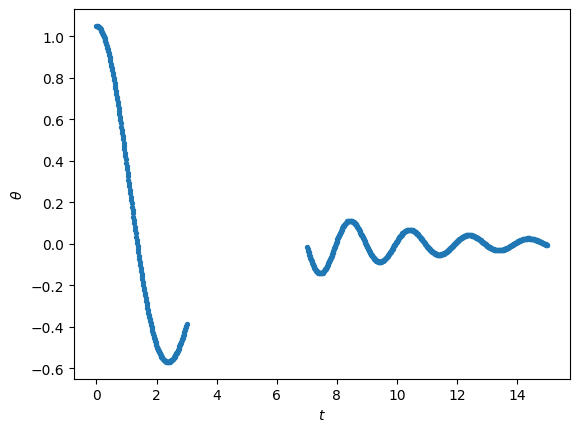

In [3]:
plt.scatter(df_train["t"], df_train["theta"], s=8)
plt.xlabel("$t$")
plt.ylabel(r"$\theta$");

In [4]:
def get_gap(df):
    col = df["t"]
    tmp = col.diff().argmax()
    return col.iloc[tmp - 1], col.iloc[tmp]

In [5]:
train_gap_start, train_gap_end = get_gap(df_train)
train_gap_start, train_gap_end

(3.003003003003003, 7.012012012012012)

In [6]:
def to_tensor(df):
    t = torch.tensor(df["t"].to_numpy())
    theta = torch.tensor(df["theta"].to_numpy())
    dtheta = torch.gradient(theta, spacing=t[1] - t[0])[0]
    d2theta = torch.gradient(dtheta, spacing=t[1] - t[0])[0]
    return torch.vstack([t, theta, dtheta, d2theta]).T

The gradients (`dtheta`, `d2theta`) significantly affect model accuracy. `torch.gradient` uses central differences, giving smoother and more accurate estimates.

I tried `torch.diff` with division by `t` (forward differences). The gradients were noisier.

In [7]:
def preprocess(df):
    gap_start, gap_end = get_gap(df)
    
    first_half = to_tensor(df[df["t"] <= gap_start])
    first_half[0, 2:] = 0
    second_half = to_tensor(df[df["t"] >= gap_end])[1: ]  # first row has no reliable dtheta and d2theta
    
    return torch.cat([first_half, second_half])

In [8]:
train_data = preprocess(df_train)
train_data.shape

torch.Size([733, 4])

In [9]:
# Constants
m = 1
g = 9.8

## Define model and train

Since we lack data near $t_F$, we can fix $t_F$ to any value within the gap when training $l$, $\mu$ and $F$.

In [10]:
class MyModel(nn.Module):
    def __init__(self, gap_t):
        super().__init__()
        self.gap_t = gap_t
        self.raw_l = nn.Parameter(torch.randn(()))
        self.raw_mu = nn.Parameter(torch.randn(()))
        self.raw_F = nn.Parameter(torch.randn(()))

    @property
    def l(self):
        return F.softplus(self.raw_l)  # positive

    @property
    def mu(self):
        return F.softplus(self.raw_mu)  # positive

    @property
    def F(self):
        return F.softplus(self.raw_F)  # positive

    def forward(self, x):
        t, theta, dtheta, d2theta = x.unbind(dim=1)
        
        F_d = self.F * torch.sin(theta)
        mask = (t >= self.gap_t)  # Pulling force acts when t >= gap_t, gap_t not accurate is ok
        F_d *= mask.float()
        
        return m * self.l * d2theta + m * g * torch.sin(theta) + self.mu * self.l * dtheta + F_d

In [11]:
def train(model, optimizer, inputs, num_epochs, logging_interval=20):
    for epoch in range(num_epochs):
        model.train()

        outputs = model(inputs).squeeze(-1)
        loss = F.mse_loss(outputs, torch.zeros_like(outputs))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % logging_interval == 0 or epoch == num_epochs - 1:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

In [12]:
@torch.no_grad()
def predict(model, inputs):
    outputs = model(inputs).squeeze(-1)
    return outputs.detach().cpu()

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyModel((train_gap_start + train_gap_end) / 2)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [14]:
train(model.to(device), optimizer, train_data.to(device), 8000, 500)

Epoch [1/8000], Loss: 4.950442129810279
Epoch [501/8000], Loss: 1.4249838911691641
Epoch [1001/8000], Loss: 1.0000725397465624
Epoch [1501/8000], Loss: 0.7183319092438403
Epoch [2001/8000], Loss: 0.5129674180525355
Epoch [2501/8000], Loss: 0.3637680810310431
Epoch [3001/8000], Loss: 0.2588443174734451
Epoch [3501/8000], Loss: 0.1890693876274591
Epoch [4001/8000], Loss: 0.14638083202753888
Epoch [4501/8000], Loss: 0.12321865981084706
Epoch [5001/8000], Loss: 0.11262000560381745
Epoch [5501/8000], Loss: 0.10879699678063263
Epoch [6001/8000], Loss: 0.1078003018617348
Epoch [6501/8000], Loss: 0.10763143667389577
Epoch [7001/8000], Loss: 0.10761509296427754
Epoch [7501/8000], Loss: 0.10761432342480177
Epoch [8000/8000], Loss: 0.10761430903049855


In [15]:
train_l, train_mu, train_F = model.l.item(), model.mu.item(), model.F.item()
train_l, train_mu, train_F

(4.9179253578186035, 0.4993065595626831, 40.134483337402344)

## Find $t_F$ and next $\theta=0$

Given a value of $t_F$, `solve_ivp` can reconstruct the graph of $\theta$ versus $t$.

To determine the true $t_F$, we compare the predicted $\theta$ values from `solve_ivp` with the observed data.
We then extend the graph a few seconds beyond the last recorded time to find the first sign change in $\theta$; this gives us $t_{\text{next zero } \theta}$.

In [16]:
train_t_end = df_train["t"].max()
train_t_end

15.0

In [17]:
train_theta0 = df_train[df_train["t"] == 0]["theta"].item()
train_theta0

1.05

In [18]:
def ivp(t_F, model, theta0, t_eval):
    
    def ode_fn(t, y, l, mu, F, t_F):
        theta, dtheta = y
        
        F_d = (F / (m * l)) * np.sin(theta) if t >= t_F else 0
        
        d2theta = -(g / l) * np.sin(theta) - (mu / m) * dtheta - F_d
        return [dtheta, d2theta]
    
    return solve_ivp(ode_fn, (0, t_eval.max().item()), (theta0, 0),
                     t_eval=t_eval, args=(model.l.item(), model.mu.item(), model.F.item(), t_F)).y[0, :]

In [19]:
def find_t_F(model, data, theta0, gap_start, gap_end, step=0.005):
    
    def loss_fn(t_F, t_eval, theta_truths):
        theta_preds = torch.tensor(ivp(t_F, model, theta0, t_eval))
        return F.mse_loss(theta_preds, theta_truths).item()

    # Loss function has a sharp jump at t=t_F, optimization such as 
    # scipy.optimize.minimize doesn't work well.
    # Here we use grid search instead.
    possible_t_F = np.arange(gap_start, gap_end, step)
    losses = [(loss_fn(t, data[:, 0], data[:, 1]), t) for t in possible_t_F]
    return min(losses)[1]

In [20]:
train_t_F = find_t_F(model, train_data, train_theta0, train_gap_start, train_gap_end)
train_t_F

4.418003003002973

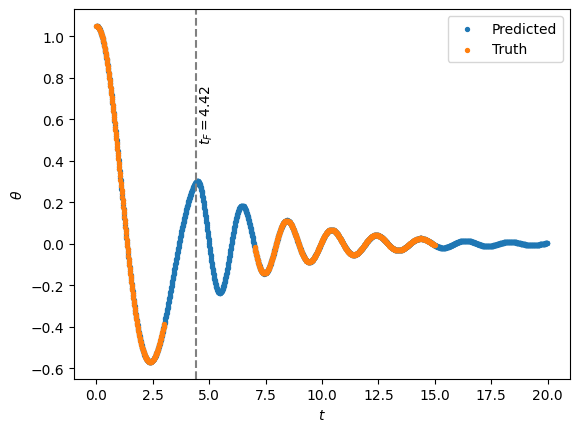

In [21]:
t_samples = np.arange(0, train_t_end + 5, 0.01)

plt.axvline(x=train_t_F, linestyle="--", color="gray")
plt.text(train_t_F + 0.1, 0.5, f"$t_F={train_t_F:.2f}$", color="black", rotation=90)
plt.scatter(t_samples, ivp(train_t_F, model, train_theta0, t_samples), s=8, label="Predicted")
plt.scatter(df_train["t"], df_train["theta"], s=8, label="Truth")
plt.xlabel("$t$")
plt.ylabel(r"$\theta$")
plt.legend();

In [22]:
def find_t_next_zero_theta(model, theta0, t_F, t_record_end, extrapolate=5, granularity=0.005):
    t_samples = np.arange(0, t_record_end + extrapolate, granularity)
    pred_thetas = ivp(t_F, model, theta0, t_samples)

    # Filter out data before the recorder is turned off
    filter_ = np.where(t_samples > t_record_end)[0]
    t_samples, pred_thetas = t_samples[filter_], pred_thetas[filter_]
    
    first_sign_change = np.where(np.diff(np.sign(pred_thetas)) != 0)[0][0]
    return abs(t_samples[first_sign_change] + t_samples[first_sign_change + 1]) / 2

In [23]:
train_t_next_zero_theta = find_t_next_zero_theta(model, train_theta0, train_t_F, train_t_end)
train_t_next_zero_theta

15.8825

## Write answers to file

In [24]:
def write_submission(model, t_F, t_next_zero_theta, filename="submission.csv"):
    df_sub = pd.DataFrame({
        "l": model.l.item(),
        "miu": model.mu.item(),
        "F": model.F.item(),
        "t_nextzerotheta": t_next_zero_theta,
        "t_Fput": t_F
    }, index=[0])
    df_sub.to_csv(filename, index=False)

In [25]:
write_submission(model, train_t_F, train_t_next_zero_theta, "submission_train.csv")

## Repeat for different sets of data (on grader only)

In [26]:
in_filenames = ["pendulum_testA.csv", "pendulum_testB.csv"]
out_filenames = ["submissionA.csv", "submissionB.csv"]
zip_filename = "submission.zip"

In [27]:
for in_filename, out_filename in zip(in_filenames, out_filenames):
    try:
        df_test = pd.read_csv(TEST_PATH / in_filename)
    except FileNotFoundError:
        df_test = None

    if df_test is not None:
        test_gap_start, test_gap_end = get_gap(df_test)
        test_data = preprocess(df_test)
        
        model.gap_t = (test_gap_start + test_gap_end) / 2

        # l, mu, F
        train(model.to(device), optimizer, test_data.to(device), 8000, 500)

        test_t_end = df_test["t"].max()
        test_theta0 = df_test[df_test["t"] == 0]["theta"].item()

        # t_F
        test_t_F = find_t_F(model, test_data, test_theta0, test_gap_start, test_gap_end)
        # t_next_zero_theta
        test_t_next_zero_theta = find_t_next_zero_theta(model, test_theta0, test_t_F, test_t_end)

        write_submission(model, test_t_F, test_t_next_zero_theta, out_filename)

In [28]:
if all([os.path.exists(filename) for filename in out_filenames]):
    with zipfile.ZipFile(zip_filename, "w") as zipf:
        for file in out_filenames:
            zipf.write(file, os.path.basename(file))

## Score

Leaderboard A:

- S1: 0.7985
- S2: 0.9571
- S3: 0.8900
- S4: 0.9753
- S5: 0.7408
- Score: 0.8710

Leaderboard B:

- S1: 0.9181
- S2: 0.5005
- S3: 0.9990
- S4: 0.9753
- S5: 0.9910
- Score: 0.9186